<a id="top"></a>
# Рекомендация тарифов
<h4 align="right">Спринт 6    |    Когорта ДС13    |    Артур Урусов</h4>

> В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

> Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Содержание

0. **[Подготовка](#0)**

    0.1. [Импорт библиотек](#0-1)
    
    0.2. [Настройка окружения](#0-2)


1. **[Получение данных](#1)**

    1.1. [Чтение файла](#1-1)
    
    1.2. [Изучение данных](#1-2)


2. **[Продготовка данных](#2)**

    2.1. [Разделение данных на выборки](#2-1)


3. **[Исследование моделей](#3)**

    3.1. [Решающее дерево](#3-1)
    
    3.2. [Случайный лес](#3-2)
    
    3.3. [Логистическая регрессия](#3-3)
    
    
4. **[Проверка моделей на тестовой выборке](#4)**

    4.1. [Решающее дерево](#4-1)
    
    4.2. [Случайный лес](#4-2)
    
    4.3. [Логистическая регрессия](#4-3)
    
    
5. **[Проверка моделей на адекватность](#5)**

    4.1. [Случайное распределение](#5-1)


6. **[Результаты исследования](#6)**

    5.1. [Общие выводы](#6-1)
    
    5.2. [Рекомендации](#6-2)

<a id="0"></a>
## Этап 0. Подготовка

<a id="0-1"></a>
### Шаг 0.1 Импорт библиотек

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

[к началу шага](#0-1) | [к началу этапа](#0) | [к началу страницы](#top)

<a id="0-2"></a>
### Шаг 0.2 Настройка окружения

In [2]:
warnings.filterwarnings('ignore')
np.seterr(all='ignore')
random_state = 42

[к началу шага](#0-2) | [к началу этапа](#0) | [к началу страницы](#top)

<a id="1"></a>
## Этап 1. Получение данных

<a id="1-1"></a>
### Шаг 1.1 Чтение файла

Прочитаем файл с данными и посмотрим основную информацию:

In [3]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.info()
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


У нас подготовленный к работе датасет, всего 3214 строк, пропущенных значений нет, предобрабатывать данные не нужно (всегда бы так 😅).

[к началу шага](#1-1) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="1-2"></a>
### Шаг 1.2 Изучение данных

Датафрейм состоит из столбцов `calls`, `minutes`, `messages`, `mb_used` и `is_ultra`. В целях исследования мы будем предсказывать значение столбца `is_ultra` основываясь на значениях в остальных столбцах.

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Исходя из этой информации можем перевести столбец `calls` в формат `int`:

In [4]:
df['calls'] = df['calls'].astype('int')

Посмотрим на значения корреляции:

In [5]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Количество звонков и количество минут находятся в очень сильной зависимости друг от друга (что вполне логично), и при этом почти одинаково влияют на столбец `is_ultra`. Поэтому от одного из показателей можно избавиться. Так как корреляция между `calls` и `is_ultra` чуть выше, удалим столбец `minutes`:

In [6]:
df.drop(labels='minutes', axis=1, inplace=True)

Так же посмотрим на основные статистические показатели датасета и построим графики:

In [7]:
df.describe()

,calls,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,38.281269,17207.673836,0.306472
std,33.236368,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,9.000000,12491.902500,0.000000
50%,62.000000,30.000000,16943.235000,0.000000
75%,82.000000,57.000000,21424.700000,1.000000
max,244.000000,224.000000,49745.730000,1.000000


Максимальные значения по звонкам и сообщениям довольно близки, однако в среднем звонки совершаются почти в два раза чаще. При этом абоненты активно потребляют интернет-трафик: больше 25% тратит не менее 12 ГБ в месяц. Максималььное значение по трафику &mdash; почти 50 ГБ. Кроме того, видим что распределение тарифов неравномерно: среднее значение примерно равно 0.3, то есть тарифом «Ultra» пользуется около 30% абонентов.

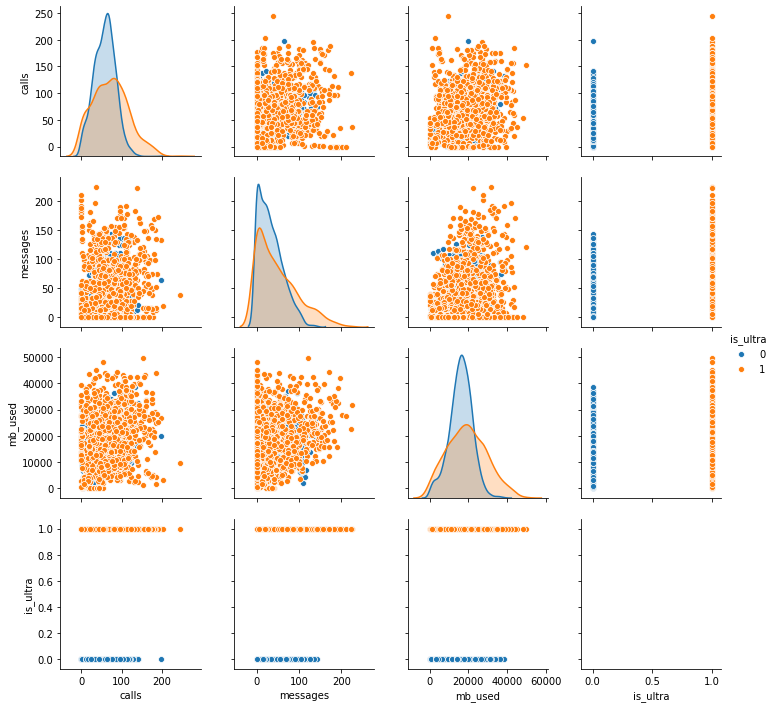

In [8]:
sns.pairplot(df, hue='is_ultra')
plt.show()

К сожалению, графики зависиомостей не дают нам однозначной картины, зато на графиках распределения плотностей явно видим разницу в пользователях двух тарифов.

[к началу шага](#1-2) | [к началу этапа](#1) | [к началу страницы](#top)

<a id="2"></a>
## Этап 2. Подготовка данных

<a id="2-1"></a>
### Шаг 2.1 Разделение данных на выборки

Для того, чтобы обучить, валидировать и протестировать модели, нам необходимо разделить датафрейм на три части: обучающую, валидационную и тестовую выборки. Разделим датасет в пропорции 80/20 на обучаюшую выборку и тестовую выборку. Обучающую выборку, в свою очередь, разделим в той же пропорции 80/20 на собственно обучающую выборку и на валидационную выборку. Также учтём неравномерное распределение тарифов в выборке и воспользуемся параметром `stratify`:

In [9]:
features = df.drop(['is_ultra'], axis=1)
target = df['is_ultra']

X_tralid, X_test, y_tralid, y_test = train_test_split(
    features, target, stratify=target, test_size=.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_tralid, y_tralid, stratify=y_tralid, test_size=.2, random_state=42)

print('Тренировочная выборка: {}.'.format(X_train.shape), 'Тренировочные результаты: {}.'.format(y_train.shape))
print('Валидационная выборка: {}.'.format(X_valid.shape), 'Валидационные результаты: {}.'.format(y_valid.shape))
print('Тренировочная + валидационная выборка: {}.'.format(X_tralid.shape), 
      'Тренировочные+ валидационные результаты: {}.'.format(y_tralid.shape))
print('Тестовая выборка: {}.'.format(X_test.shape), 'Тестовые результаты: {}.'.format(y_test.shape))

Тренировочная выборка: (2056, 3). Тренировочные результаты: (2056,).
Валидационная выборка: (515, 3). Валидационные результаты: (515,).
Тренировочная + валидационная выборка: (2571, 3). Тренировочные+ валидационные результаты: (2571,).
Тестовая выборка: (643, 3). Тестовые результаты: (643,).


[к началу шага](#2-1) | [к началу этапа](#2) | [к началу страницы](#top)

<a id="3"></a>
## Этап 3. Исследование моделей

Так как нам нужно предсказать значение столбца `is_ultra`, который принимает значения 0 (тариф «Smart») и 1 (тариф «Ultra»), наша задача сводится к бинарной классификации. Поэтому мы будем вибирать лучшую из трёх моделей, доступных в библиотеках Scikit Learn:
- решающее дерево (`DecisionTreeClassifier`);
- случайный лес (`RandomForestClassifier`);
- логистическая регрессия (`LogisticRegression`).

Определим функцию для поиска лучших гиперпараметров:

In [10]:
#  объявляем переменные для хранения лучших гиперпараметров и метрик
tree_best, forest_best, logreg_best = {}, {}, {}
tree_stats, forest_stats, logreg_stats = ['Решающее дерево'], ['Случайный лес'], ['Логистическая регрессия']

def grid_search(clf, grid_params):
    global tree_best, forest_best, logreg_best  #  обращаемся к переменным как к глобальным
    
    #  с помощью поиска по сетке определяем наилучшую версию модели
    grid = GridSearchCV(clf, grid_params, scoring = 'accuracy', cv=5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    #  выводим информацию о наилучшей версии модели
    print('Гиперпараметры наилучшей модели:', grid.best_params_)
    print('Accuracy наилучшей модели на обучающей выборке:', grid.best_score_)
    print('Accuracy наилучшей модели на валидационной выборке:', accuracy_score(y_valid, grid.predict(X_valid)))
    
    #  сохраняем гиперпараметры и метрики точности лучшей версии модели
    if  type(clf).__name__ == 'DecisionTreeClassifier':
        tree_best = grid.best_params_
        tree_stats.extend([grid.best_score_, accuracy_score(y_valid, grid.predict(X_valid))])
    elif type(clf).__name__ == 'RandomForestClassifier':
        forest_best = grid.best_params_
        forest_stats.extend([grid.best_score_, accuracy_score(y_valid, grid.predict(X_valid))])
    else:
        logreg_best = grid.best_params_
        logreg_stats.extend([grid.best_score_, accuracy_score(y_valid, grid.predict(X_valid))])

<a id="3-1"></a>
### Шаг 3.1 Решающее дерево

Начнём с решающего дерева.

In [11]:
%%time
tree_clf = DecisionTreeClassifier(random_state=random_state)
tree_params = {'max_depth': range(1, 11),
               'criterion': ['entropy', 'gini']}

print('Решающее дерево')
grid_search(tree_clf, tree_params)

Решающее дерево
Гиперпараметры наилучшей модели: {'criterion': 'entropy', 'max_depth': 3}
Accuracy наилучшей модели на обучающей выборке: 0.7879377431906615
Accuracy наилучшей модели на валидационной выборке: 0.7922330097087379
CPU times: user 861 ms, sys: 7.34 ms, total: 868 ms
Wall time: 881 ms


Самым лучшим для решающего дерева оказался набор гиперпараметров `{'criterion': 'entropy', 'max_depth': 3}`. Точность и на обучающей выборке, и на валидационной выборке примерно **0.79**. Это лучше, чем **0.75** по условию, поэтому нам подходит.

[к началу шага](#3-1) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-2"></a>
### Шаг 3.2 Случайный лес

Теперь настал черёд случайного леса.

In [12]:
%%time
forest_clf = RandomForestClassifier(random_state=random_state)
forest_params = {'n_estimators': range(10, 151, 10),
               'max_depth': range(1, 11), 
               'criterion': ['entropy', 'gini']}

print('Случайный лес')
grid_search(forest_clf, forest_params)

Случайный лес
Гиперпараметры наилучшей модели: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}
Accuracy наилучшей модели на обучающей выборке: 0.8103112840466926
Accuracy наилучшей модели на валидационной выборке: 0.8077669902912621
CPU times: user 5min 34s, sys: 2.19 s, total: 5min 37s
Wall time: 5min 37s


После долгих пяти с половиной минут перебора самым лучшим набором гиперпараметров для случайного леса оказался `{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}`. Точность на обучающей выборке и на валидационной выборке примерно **0.81**. Это пока лучший результат, и точно луше чем **0.75** по условию, поэтому пока это наш основной вариант.

[к началу шага](#3-2) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="3-3"></a>
### Шаг 3.3 Логистическая регрессия

Найдём лучшие гиперпараметры для логистической регрессии:

In [13]:
%%time
logreg_clf = LogisticRegression(random_state=random_state)
logreg_params = [
  {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
  {'penalty': ['l2'], 'solver': ['liblinear', 'saga', 'sag', 'lbfgs', 'newton-cg'], 'C': [0.1, 0.5, 1, 5, 10, 50, 100]},
  ]

print('Логистическая регрессия')
grid_search(logreg_clf, logreg_params)

Логистическая регрессия
Гиперпараметры наилучшей модели: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy наилучшей модели на обучающей выборке: 0.7436770428015564
Accuracy наилучшей модели на валидационной выборке: 0.7495145631067961
CPU times: user 9.16 s, sys: 15.9 ms, total: 9.18 s
Wall time: 9.21 s


Логистическая регрессия оказалась хуже, чем другие варианты. Лучший набор гиперпараметров: `{'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}`. Самая низкая точность на обучающей выборке **0.74**, на валидационной выборке совсем немного не хватило до чистых **0.75** по условию. Пока не отбрасываем этот вариант, но он для нас наименее приоритетный.

[к началу шага](#3-3) | [к началу этапа](#3) | [к началу страницы](#top)

<a id="4"></a>
## Этап 4. Проверка моделей на тестовой выборке

Кроме проверки на тренировочной и валидационной выборках, сделаем контрольную проверку моделей на тестовой выборке. Перед этим обучим модели на объединённой тренировочной и валидационной выборках. А для сбора результатов напишем функцию:

In [14]:
def test_score(clf):
    #  тренируем модель на объединённой обучающей и валидационной выборке
    clf.fit(X_tralid, y_tralid)
    
    #  выводим метрики модели
    print('Accuracy модели на тренировочной выборке:', accuracy_score(y_tralid, clf.predict(X_tralid)))
    print('Accuracy модели на тестовой выборке:', accuracy_score(y_test, clf.predict(X_test)))
    
    #  сохраняем метрики точности
    if  type(clf).__name__ == 'DecisionTreeClassifier':
        tree_stats.extend([accuracy_score(y_tralid, clf.predict(X_tralid)), accuracy_score(y_test, clf.predict(X_test))])
    elif type(clf).__name__ == 'RandomForestClassifier':
        forest_stats.extend([accuracy_score(y_tralid, clf.predict(X_tralid)), accuracy_score(y_test, clf.predict(X_test))])
    else:
        logreg_stats.extend([accuracy_score(y_tralid, clf.predict(X_tralid)), accuracy_score(y_test, clf.predict(X_test))])

<a id="4-1"></a>
### Шаг 4.1 Решающее дерево

Начнём с дерева, но уже не будем перебирать все варианты глубины, а выберем лучший: `{'criterion': 'entropy', 'max_depth': 3}`:

In [15]:
tree_clf = DecisionTreeClassifier(**tree_best, random_state=random_state)
print('Решающее дерево. Параметры:', tree_best)

test_score(tree_clf)

Решающее дерево. Параметры: {'criterion': 'entropy', 'max_depth': 3}
Accuracy модели на тренировочной выборке: 0.793076623881758
Accuracy модели на тестовой выборке: 0.8009331259720062


На объединённой выборке точность всё так же примерно **0.79**, а на тестовой даже подросла до **0.8**. Это всё ещё лучше, чем **0.75** по условию.

[к началу шага](#4-1) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="4-2"></a>
### Шаг 4.2 Случайный лес

Для леса сразу выберем лучшие значения гиперпараметров `{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}`:

In [16]:
forest_clf = RandomForestClassifier(**forest_best, random_state=random_state)
print('Случайный лес. Параметры:', forest_best)

test_score(forest_clf)

Случайный лес. Параметры: {'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}
Accuracy модели на тренировочной выборке: 0.8595877090626215
Accuracy модели на тестовой выборке: 0.8149300155520995


На объединённой выборке точность выросла аж до почти **0.86**, а на тестовой всё те же примерно **0.81**. Это всё ещё лучший результат, и лучше чем **0.75** по условию.

[к началу шага](#4-2) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="4-3"></a>
### Шаг 4.3 Логистическая регрессия

Посмотрим как поведёт себя логистическая регрессия на тестовой выборке. Набор гиперпараметров `{'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}`:

In [17]:
logreg_clf = LogisticRegression(**logreg_best, random_state=random_state)
print('Логистическая регрессия. Параметры:', logreg_best)

test_score(logreg_clf)

Логистическая регрессия. Параметры: {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy модели на тренировочной выборке: 0.7440684558537534
Accuracy модели на тестовой выборке: 0.7433903576982893


Чуда не произошло. Логистическая регрессия всё еще хуже, чем другие варианты. Самая низкая точность как на объединённой, так и на тестовой выборке: **0.74**. Логистическая регрессия так и не дотянула до необходимых **0.75** по условию, то есть она нам явно не подходит.

[к началу шага](#4-3) | [к началу этапа](#4) | [к началу страницы](#top)

<a id="5"></a>
## Этап 5. Проверка моделей на адекватность

<a id="5-1"></a>
### Шаг 5.1 Случайное распределение

Чтобы проверить, что наши модели адекватно строят зависимости и действительно предсказывают значения, воспользуемся случайным распределением для проверки на адекватность. Для этого мы создадим выборку со случайным распределением и проверим насколько точность и корень из среднеквадратическая ошибки отличаются от наших моделей:

In [18]:
dummy_clf = DummyClassifier(random_state=random_state)
dummy_clf.fit(X_tralid, y_tralid)
predictions_sanity = dummy_clf.predict(X_test)

print('Случайное распределение')
print('Accuracy модели на тренировочной выборке:', dummy_clf.score(X_tralid, y_tralid))
print('Accuracy модели на тестовой выборке:', accuracy_score(y_test, predictions_sanity))

dummy_stats = ['Случайное распределение', 
               None, 
               None, 
               dummy_clf.score(X_tralid, y_tralid), 
               accuracy_score(y_test, predictions_sanity)]

Случайное распределение
Accuracy модели на тренировочной выборке: 0.5772073123298328
Accuracy модели на тестовой выборке: 0.5909797822706065


Для случайной выборки характерна самая низкая точность: **0.57** на объединённой выборке и **0.59** на тестовой (худшая у логистической регрессии **0.74**). Как видим, точность для случайного распределения близка к **50%**, как и должно быть. Посмотрим на результаты моделей в табличке:

In [19]:
stats = pd.DataFrame([tree_stats, forest_stats, logreg_stats, dummy_stats], 
                     columns=['model', 'train', 'valid', 'tralid', 'test'])

display(stats.sort_values(by='test', ascending=False))

,model,train,valid,tralid,test
1,Случайный лес,0.810311,0.807767,0.859588,0.814930
0,Решающее дерево,0.787938,0.792233,0.793077,0.800933
2,Логистическая регрессия,0.743677,0.749515,0.744068,0.743390
3,Случайное распределение,NaN,NaN,0.577207,0.590980


Как видим, все наши модели показали результаты лучше, чем при случайном заполнении, то есть прошли **sanity check**. Даже логистическая регрессия, которая не прошла по условию поставленной задачи, всё равно выдаёт адекватный результат, хоть и его точность нас не удовлетворяет.

[к началу шага](#5-1) | [к началу этапа](#5) | [к началу страницы](#top)

<a id="6"></a>
## Этап 6. Результаты исследования

<a id="6-1"></a>
### Шаг 6.1 Общие выводы

В этом исследовании мы подбирали наилучшую модель для подбора тарифа, который стоит предложить пользователю в зависимости от количества звонков и смс и потребляемого интернет-трафика. Так как тарифа всего два, задача свелась к бинарной классификации.

В рамках задачи бинарной классификации мы рассмотрели 3 модели:
- решающее дерево (`DecisionTreeClassifier`);
- случайный лес (`RandomForestClassifier`);
- логистическая регрессия (`LogisticRegression`).

Каждую модель мы обучили на нескольких типах выборок: первое обучение происходило на предварительной выборке 80% от всего датасета, который мы в свою очередь разделили в пропорции 80/20 на обучающую (64% от всех данных) и валидационную (16% от всех данных) выборки. Затем, после определения наилучших гиперпараметров для каждой модели мы заново обучили их на объединённой обучающей и валидационной (80% от всех данных) выборке, а точность проверили на тестовой выборке (20% данных). Во всех выборках тарифы были представлены в одинаковых пропорциях, характерных для всего датасета.

Для всех моделей мы подбирали наилучшие гиперпараметры. Для дерева наилучший результат был достигнут при наборе гиперпараметров `{'criterion': 'entropy', 'max_depth': 3}`, для леса &mdash; при значениях гиперпараметров `{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}`, а для логистической регрессии &mdash; `{'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}`.

По предварительному условию, удовлетворительной считается модель со значением accuracy не менее 0.75. Мы проверили accuracy для каждой модели, и только у решающего дерева и случайного леса точность выше удовлетворительной. Логистическая регрессия, увы, не может быть рекомендована к использованию.

Также мы провели **sanity check** для всех трёх моделей (в том числе и для логистической регрессии). Все три модели дают заметно лучшие результаты, чем просто случайное распределение, то есть проверка пройдена всеми моделями.

Резюмируя, можно сказать что в целях предложения подходящего тарифа допустимо использовать решающее дерево и случайный лес. Рекомендованные гиперпараметры: `{'criterion': 'entropy', 'max_depth': 3}` для дерева, `{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}` для леса.

Самая лучшая точность (**0.81**) достигнута с помощью модели случайного леса с гиперпараметрами `{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 100}`.

[к началу шага](#6-1) | [к началу этапа](#6) | [к началу страницы](#top)